In [1]:
rm(list=ls())
suppressPackageStartupMessages(library("dplyr"))
suppressPackageStartupMessages(library("ggplot2"))
suppressPackageStartupMessages(library("Seurat"))
library("doParallel")
library("alakazam")
library("shazam")
setwd("D:/Storage/Ali/10x/Year2/mergeBCR/data_v2")
subject = "P05"
path.data = file.path("D:","Storage","Ali","10x","Year2","mergeBCR","data")
BCR.data = read.table(paste0(path.data, "/", subject,"_p.tsv"), 
                     header=TRUE, sep="\t",as.is=T,stringsAsFactors = FALSE)

Loading required package: foreach

Loading required package: iterators

Loading required package: parallel

As of v1.0.0 the AIRR Rearrangement schema is now the default file format.
A description of the standard is available at https://docs.airr-community.org.
The legacy Change-O format is supported through arguments to each function
that allow the input column names to be explicitly defined.

As of v1.0.0 the AIRR Rearrangement schema is now the default file format.
A description of the standard is available at https://docs.airr-community.org.
The legacy Change-O format is supported through arguments to each function
that allow the input column names to be explicitly defined.



In [2]:
data = as.data.frame(BCR.data %>% 
        #rename(MU_FREQ = mu_freq) %>%
        rowwise() %>%
        mutate(cell_id_unique = ifelse(DATATYPE == "singleCell", 
                     paste(SAMPLE, strsplit(CELL, split = "-")[[1]][1], sep = "_"), NA))
        )             
dim(data)
# get non-single cell data
data.ns = filter(data, DATATYPE!="singleCell")
dim(data.ns)
# get single cell data
data.single = filter(data, DATATYPE=="singleCell")
# remove cells which have multipleble heavy chain
dim(data.single)
index.bar.dup = which(duplicated(data.single$cell_id_unique))
length(index.bar.dup)

[1] 383615     60

[1] 164880     60

[1] 218735     60

[1] 2132

In [3]:
BCR.data$CELL[1:10]
BCR.data$SAMPLE[1:10]
data.single$cell_id_unique[1:10]
length((data.single$cell_id_unique))
length(unique(data.single$cell_id_unique))
length(unique(data$CELL))

[1] NA                   "CGTTAGAGTGGACGAT-1" "AGGTCATGTCCCGACA-1"
 [4] "TACGGATCAGGTGCCT-1" NA                   "ATGTGTGTCGTTACGA-1"
 [7] NA                   "AGCATACTCAAACGGG-1" "GTTCGGGTCGCTTAGA-1"
[10] "GTGCAGCGTGACAAAT-1"

[1] "P05_BMPC_d90_Y1"         "P05_FNA_d7_1_Y2"        
 [3] "P05_FNA_d28_1_Y1"        "P05_FNA_d12_1_Y1"       
 [5] "P05_PBMC_d0_Y1"          "P05_IgD-BCell_d180_1_Y1"
 [7] "P05_BMPC_d180_Y1"        "P05_FNA_d7_2_Y2"        
 [9] "P05_IgD-BCell_d0_1_Y1"   "P05_IgD-BCell_d0_1_Y2"

[1] "P05_FNA_d7_1_Y2_CGTTAGAGTGGACGAT"        
 [2] "P05_FNA_d28_1_Y1_AGGTCATGTCCCGACA"       
 [3] "P05_FNA_d12_1_Y1_TACGGATCAGGTGCCT"       
 [4] "P05_IgD-BCell_d180_1_Y1_ATGTGTGTCGTTACGA"
 [5] "P05_FNA_d7_2_Y2_AGCATACTCAAACGGG"        
 [6] "P05_IgD-BCell_d0_1_Y1_GTTCGGGTCGCTTAGA"  
 [7] "P05_IgD-BCell_d0_1_Y2_GTGCAGCGTGACAAAT"  
 [8] "P05_PBMC_d90_2_Y1_CTAGTGATCATAACCG"      
 [9] "P05_FNA_d0_2_Y1_GCGGGTTTCGAATGGG"        
[10] "P05_FNA_d0_1_Y2_AACTGGTTCTCGAGTA"

[1] 218735

[1] 216603

[1] 184456

In [4]:
#  remove cells with multiple heavy chains
if(length(index.bar.dup)>0){
    bar.dup = unique(data.single$cell_id_unique[index.bar.dup])
    data.single = filter(data.single, !cell_id_unique %in% bar.dup) 
}
dim(data.single)
data.P05_IgD_BCell_d6_1_Y2 = filter(data.single, SAMPLE == "P05_IgD-BCell_d6_1_Y2")
data.P05_BMPC_d0_2_Y2 = filter(data.single,SAMPLE == "P05_BMPC_d0_2_Y2")
data.P05_PBMC_d180_2_Y1 = filter(data.single, SAMPLE == "P05_PBMC_d180_2_Y1")
data.P05_BMPC_d0_1_Y2 = filter(data.single,SAMPLE == "P05_BMPC_d0_1_Y2")

# Two year 1 sample processed with Year 2 data: "P05_PBMC_d90_2_Y1" and "P05_PBMC_d180_2_Y1"
data.else = filter(data.single, (SAMPLE !="P05_PBMC_d180_2_Y1")  
                      & (SAMPLE !="P05_IgD-BCell_d6_1_Y2") & (SAMPLE !="P05_BMPC_d0_1_Y2")
                     & (SAMPLE !="P05_BMPC_d0_2_Y2"))

dim(data.else)
dim(data.P05_IgD_BCell_d6_1_Y2)
dim(data.P05_BMPC_d0_2_Y2)
dim(data.P05_PBMC_d180_2_Y1)
dim(data.P05_BMPC_d0_1_Y2)


[1] 214509     60

[1] 197452     60

[1] 4282   60

[1] 2432   60

[1] 7297   60

[1] 3046   60

In [5]:
source("OverlapHeatmap_singlecell.R")
dim(data.else)
# remove duplicated cells
data.else = removeSingleCellDuplicates(data.else, group="SAMPLE", cell="CELL", seq="SEQUENCE_IMGT")
dim(data.else)


Attaching package: 'gplots'


The following object is masked from 'package:stats':

    lowess



Attaching package: 'reshape'


The following object is masked from 'package:dplyr':

    rename




[1] 197452     60

Remove duplicates - cycle  1 


[1] 195339     60

### check overlap between P05_BMPC_d0_2_Y2 and P05_IgD_BCell_d6_1_Y2

In [6]:
cell.BCR.P05_BMPC_d0_2_Y2 = data.P05_BMPC_d0_2_Y2$CELL
cell.BCR.P05_IgD_BCell_d6_1_Y2 = data.P05_IgD_BCell_d6_1_Y2$CELL
length(unique(intersect(cell.BCR.P05_BMPC_d0_2_Y2, cell.BCR.P05_IgD_BCell_d6_1_Y2)))
length(unique(intersect(data.P05_BMPC_d0_2_Y2$SEQUENCE_IMGT, data.P05_IgD_BCell_d6_1_Y2$SEQUENCE_IMGT)))

overlapped.cells = c()
for(i in 1:length(cell.BCR.P05_BMPC_d0_2_Y2)){
    for(j in 1:length(cell.BCR.P05_IgD_BCell_d6_1_Y2)){
        if(cell.BCR.P05_BMPC_d0_2_Y2[i] == cell.BCR.P05_IgD_BCell_d6_1_Y2[j]){
            if(data.P05_BMPC_d0_2_Y2$SEQUENCE_IMGT[i] == data.P05_IgD_BCell_d6_1_Y2$SEQUENCE_IMGT[j]){
                overlapped.cells = c(overlapped.cells, cell.BCR.P05_BMPC_d0_2_Y2[i])
            }
        }
    }
}
length(overlapped.cells)

[1] 1123

[1] 1000

[1] 1000

In [7]:
# Load mappings
path.data = file.path("C:","Project","workspace", "AliFlu","10x", "data")
mapping.file = file.path(path.data, "data_mapping", "map_GEX.txt")
mappings = read.delim(mapping.file, stringsAsFactors = FALSE, as.is=T)
sample = "P05_BMPC_d0_2_Y2"
samplePath = mappings$SamplePath[which(mappings$SampleName == sample)]
dir.name.full = paste0(path.data, samplePath,"/outs/filtered_feature_bc_matrix")
data <- Read10X(data.dir = dir.name.full)
obj <- CreateSeuratObject(counts = data, project = sample)
cell.GEX.P05_BMPC_d0_2_Y2 = Cells(obj)

sample = "P05_IgD-BCell_d6_1_Y2"
samplePath = mappings$SamplePath[which(mappings$SampleName == sample)]
dir.name.full = paste0(path.data, samplePath,"/outs/filtered_feature_bc_matrix")
data <- Read10X(data.dir = dir.name.full)
obj <- CreateSeuratObject(counts = data, project = sample)
cell.GEX.P05_IgD_BCell_d6_1_Y2 = Cells(obj)

### Barcode overlap between GEX and BCR data

BCR.P05_BMPC_d0_2_Y2 BCR.P05_IgD_BCell_d6_1_Y2
BCR.P05_BMPC_d0_2_Y2      2432                 1123                     
BCR.P05_IgD_BCell_d6_1_Y2 1123                 4282                     
GEX.P05_BMPC_d0_2_Y2      2088                 1155                     
GEX.P05_IgD_BCell_d6_1_Y2   21                 2813                     
                          GEX.P05_BMPC_d0_2_Y2 GEX.P05_IgD_BCell_d6_1_Y2
BCR.P05_BMPC_d0_2_Y2      2088                   21                     
BCR.P05_IgD_BCell_d6_1_Y2 1155                 2813                     
GEX.P05_BMPC_d0_2_Y2      4521                   39                     
GEX.P05_IgD_BCell_d6_1_Y2   39                 4990

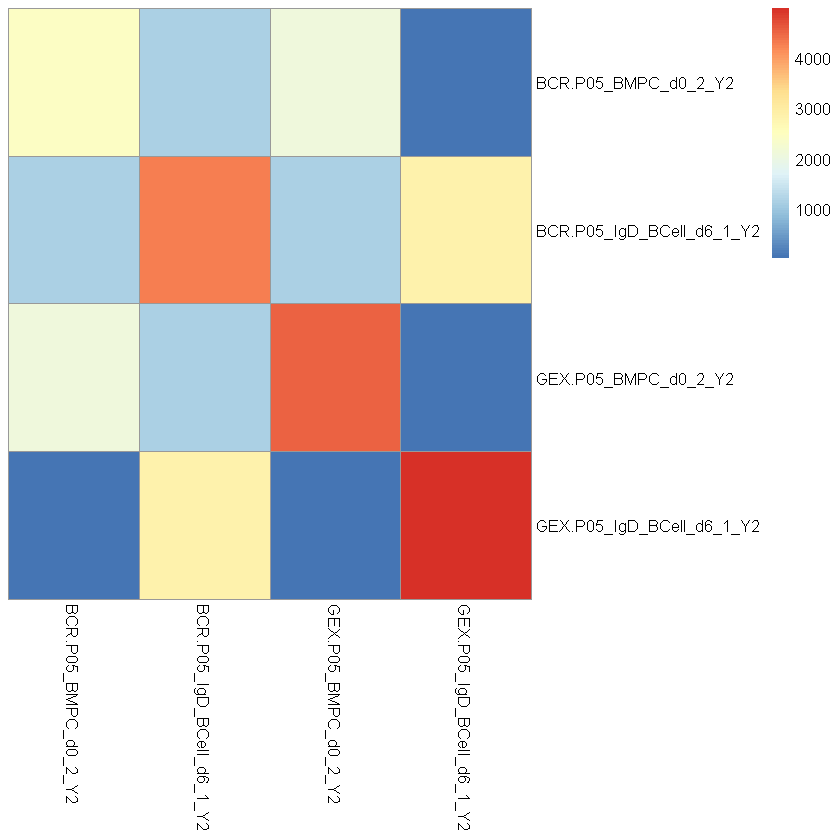

In [8]:
library("pheatmap")
samples= c("BCR.P05_BMPC_d0_2_Y2", "BCR.P05_IgD_BCell_d6_1_Y2",
          "GEX.P05_BMPC_d0_2_Y2","GEX.P05_IgD_BCell_d6_1_Y2")
cell.list = list(cell.BCR.P05_BMPC_d0_2_Y2,cell.BCR.P05_IgD_BCell_d6_1_Y2,
                cell.GEX.P05_BMPC_d0_2_Y2,cell.GEX.P05_IgD_BCell_d6_1_Y2)
overlap.matrix = matrix(nrow=length(samples), ncol=length(samples))
colnames(overlap.matrix) = samples
rownames(overlap.matrix) = samples
for(i in 1:length(samples)){
    for(j in 1:length(samples)){
            overlap.matrix[i,j] = length(intersect(cell.list[[i]], cell.list[[j]]))
        }
}
overlap.matrix
pheatmap(overlap.matrix, cluster_rows = FALSE, cluster_cols = FALSE)

In [9]:
# check overlap between 1000 duplicated BCR cells and cells between BCR and GEX
length(intersect(overlapped.cells, cell.GEX.P05_BMPC_d0_2_Y2))
length(intersect(overlapped.cells, cell.GEX.P05_IgD_BCell_d6_1_Y2))
# Is this the evidence that PBMC_ASC cells contaminated IgD- B cells?

[1] 1000

[1] 2

In [10]:
#1: P05_BMPC_d0_2_Y2 
#2: P05_IgD_BCell_d6_1_Y2
#A: overlap of BCR between P05_BMPC_d0_2_Y2 and P05_IgD_BCell_d6_1_Y2 = overlapped.cells
#B: BCR only in P05_BMPC_d0_2_Y2
#C: BCR only in P05_IgD_BCell_d6_1_Y2
length(overlapped.cells)
A1 = intersect(overlapped.cells, cell.GEX.P05_BMPC_d0_2_Y2)
A2 = intersect(overlapped.cells, cell.GEX.P05_IgD_BCell_d6_1_Y2)
A12 = intersect(overlapped.cells, intersect(cell.GEX.P05_BMPC_d0_2_Y2, cell.GEX.P05_IgD_BCell_d6_1_Y2))
A0 = which(!(overlapped.cells %in% c(cell.GEX.P05_BMPC_d0_2_Y2, cell.GEX.P05_IgD_BCell_d6_1_Y2)))
A1=A1[-which(A1 %in% A12)]
A2=A2[-which(A2 %in% A12)]
length(A1)
length(A2)
length(A12)
length(A0)

[1] 1000

[1] 998

[1] 0

[1] 2

[1] 0

In [11]:
overlapped.cells[1]
cell.GEX.P05_BMPC_d0_2_Y2[1]

[1] "ACACCCTCAAAGGTGC-1"

[1] "AAACCTGAGACATAAC-1"

In [12]:
B = cell.BCR.P05_BMPC_d0_2_Y2[which(!(cell.BCR.P05_BMPC_d0_2_Y2 %in% overlapped.cells))]
length(B)
B1 = intersect(B, cell.GEX.P05_BMPC_d0_2_Y2)
B2 = intersect(B, cell.GEX.P05_IgD_BCell_d6_1_Y2)
B12 = intersect(B, intersect(cell.GEX.P05_BMPC_d0_2_Y2, cell.GEX.P05_IgD_BCell_d6_1_Y2))
B0 = which(!(B %in% c(cell.GEX.P05_BMPC_d0_2_Y2, cell.GEX.P05_IgD_BCell_d6_1_Y2)))
B1=B1[-which(B1 %in% B12)]
B2=B2[-which(B2 %in% B12)]
length(B1)
length(B2)
length(B12)
length(B0)

[1] 1432

[1] 1072

[1] 3

[1] 16

[1] 341

In [13]:
C = cell.BCR.P05_IgD_BCell_d6_1_Y2[which(!(cell.BCR.P05_IgD_BCell_d6_1_Y2 %in% overlapped.cells))]
length(C)
C1 = intersect(C, cell.GEX.P05_BMPC_d0_2_Y2)
C2 = intersect(C, cell.GEX.P05_IgD_BCell_d6_1_Y2) 
C12 = intersect(C, intersect(cell.GEX.P05_BMPC_d0_2_Y2, cell.GEX.P05_IgD_BCell_d6_1_Y2))
C0 = which(!(C %in% c(cell.GEX.P05_BMPC_d0_2_Y2, cell.GEX.P05_IgD_BCell_d6_1_Y2)))
C1=C1[-which(C1 %in% C12)]
C2=C2[-which(C2 %in% C12)]
length(C1)
length(C2)
length(C12)
length(C0)

[1] 3282

[1] 137

[1] 2793

[1] 18

[1] 334

In [14]:
# Keep B and A1 for P05_BMPC_d0_2_Y2
# Keep C2 for P05_IgD_BCell_d6_1_Y2
dim(data.P05_BMPC_d0_2_Y2)
dim(data.P05_IgD_BCell_d6_1_Y2)
data.P05_BMPC_d0_2_Y2.s = filter(data.P05_BMPC_d0_2_Y2, CELL %in% c(B, A1))
data.P05_IgD_BCell_d6_1_Y2.s = filter(data.P05_IgD_BCell_d6_1_Y2, CELL %in% C)
dim(data.P05_BMPC_d0_2_Y2.s)
dim(data.P05_IgD_BCell_d6_1_Y2.s)

[1] 2432   60

[1] 4282   60

[1] 2430   60

[1] 3282   60

### check overlap between P05_BMPC_d0_1_Y2 and P05_PBMC_d180_2_Y1

In [15]:
cell.BCR.P05_BMPC_d0_1_Y2 = data.P05_BMPC_d0_1_Y2$CELL
cell.BCR.P05_PBMC_d180_2_Y1 = data.P05_PBMC_d180_2_Y1$CELL
length(unique(intersect(cell.BCR.P05_BMPC_d0_1_Y2, cell.BCR.P05_PBMC_d180_2_Y1)))
length(unique(intersect(data.P05_BMPC_d0_1_Y2$SEQUENCE_IMGT, data.P05_PBMC_d180_2_Y1$SEQUENCE_IMGT)))

overlapped.cells = c()
for(i in 1:length(cell.BCR.P05_BMPC_d0_1_Y2)){
    for(j in 1:length(cell.BCR.P05_PBMC_d180_2_Y1)){
        if(cell.BCR.P05_BMPC_d0_1_Y2[i] == cell.BCR.P05_PBMC_d180_2_Y1[j]){
            if(data.P05_BMPC_d0_1_Y2$SEQUENCE_IMGT[i] == data.P05_PBMC_d180_2_Y1$SEQUENCE_IMGT[j]){
                overlapped.cells = c(overlapped.cells, cell.BCR.P05_BMPC_d0_1_Y2[i])
            }
        }
    }
}
length(overlapped.cells)

[1] 2316

[1] 2155

[1] 2255

In [16]:
# Load mappings
path.data = file.path("C:","Project","workspace", "AliFlu","10x", "data")
mapping.file = file.path(path.data, "data_mapping", "map_GEX.txt")
mappings = read.delim(mapping.file, stringsAsFactors = FALSE, as.is=T)
sample = "P05_BMPC_d0_1_Y2"
samplePath = mappings$SamplePath[which(mappings$SampleName == sample)]
dir.name.full = paste0(path.data, samplePath,"/outs/filtered_feature_bc_matrix")
data <- Read10X(data.dir = dir.name.full)
obj <- CreateSeuratObject(counts = data, project = sample)
cell.GEX.P05_BMPC_d0_1_Y2 = Cells(obj)

sample = "P05_IgD−BCell_d180_2_Y1"
samplePath = mappings$SamplePath[which(mappings$SampleName == sample)]
dir.name.full = paste0(path.data, samplePath,"/outs/filtered_feature_bc_matrix")
data <- Read10X(data.dir = dir.name.full)
obj <- CreateSeuratObject(counts = data, project = sample)
cell.GEX.P05_PBMC_d180_2_Y1 = Cells(obj)

### Barcode overlap between GEX and BCR data

BCR.P05_BMPC_d0_1_Y2 BCR.P05_PBMC_d180_2_Y1
BCR.P05_BMPC_d0_1_Y2   3046                 2316                  
BCR.P05_PBMC_d180_2_Y1 2316                 7297                  
GEX.P05_BMPC_d0_1_Y2   2672                 2380                  
GEX.P05_PBMC_d180_2_Y1   17                 4782                  
                       GEX.P05_BMPC_d0_1_Y2 GEX.P05_PBMC_d180_2_Y1
BCR.P05_BMPC_d0_1_Y2   2672                   17                  
BCR.P05_PBMC_d180_2_Y1 2380                 4782                  
GEX.P05_BMPC_d0_1_Y2   5436                   44                  
GEX.P05_PBMC_d180_2_Y1   44                 6179

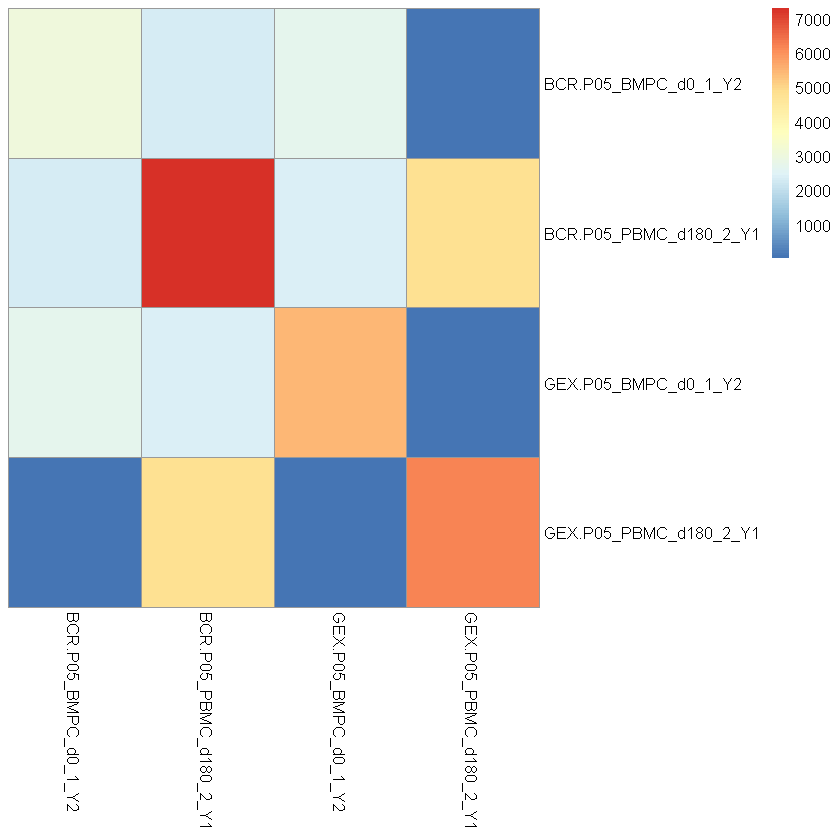

In [17]:
library("pheatmap")
samples= c("BCR.P05_BMPC_d0_1_Y2", "BCR.P05_PBMC_d180_2_Y1",
          "GEX.P05_BMPC_d0_1_Y2","GEX.P05_PBMC_d180_2_Y1")
cell.list = list(cell.BCR.P05_BMPC_d0_1_Y2,cell.BCR.P05_PBMC_d180_2_Y1,
                cell.GEX.P05_BMPC_d0_1_Y2,cell.GEX.P05_PBMC_d180_2_Y1)
overlap.matrix = matrix(nrow=length(samples), ncol=length(samples))
colnames(overlap.matrix) = samples
rownames(overlap.matrix) = samples
for(i in 1:length(samples)){
    for(j in 1:length(samples)){
            overlap.matrix[i,j] = length(intersect(cell.list[[i]], cell.list[[j]]))
        }
}
overlap.matrix
pheatmap(overlap.matrix, cluster_rows = FALSE, cluster_cols = FALSE)

In [18]:
# check overlap between 1000 duplicated BCR cells and cells between BCR and GEX
length(intersect(overlapped.cells, cell.GEX.P05_BMPC_d0_1_Y2))
length(intersect(overlapped.cells, cell.GEX.P05_PBMC_d180_2_Y1))
# Is this the evidence that PBMC_ASC cells contaminated IgD- B cells?

[1] 2249

[1] 6

In [19]:
#1: P05_BMPC_d0_1_Y2 
#2: P05_PBMC_d180_2_Y1
#A: overlap of BCR between P05_BMPC_d0_1_Y2 and P05_PBMC_d180_2_Y1 = overlapped.cells
#B: BCR only in P05_BMPC_d0_1_Y2
#C: BCR only in P05_PBMC_d180_2_Y1
length(overlapped.cells)
A1 = intersect(overlapped.cells, cell.GEX.P05_BMPC_d0_1_Y2)
A2 = intersect(overlapped.cells, cell.GEX.P05_PBMC_d180_2_Y1)
A12 = intersect(overlapped.cells, intersect(cell.GEX.P05_BMPC_d0_1_Y2, cell.GEX.P05_PBMC_d180_2_Y1))
A0 = which(!(overlapped.cells %in% c(cell.GEX.P05_BMPC_d0_1_Y2, cell.GEX.P05_PBMC_d180_2_Y1)))
A1=A1[-which(A1 %in% A12)]
A2=A2[-which(A2 %in% A12)]
length(A1)
length(A2)
length(A12)
length(A0)

[1] 2255

[1] 2243

[1] 0

[1] 6

[1] 6

In [20]:
overlapped.cells[1]
cell.GEX.P05_BMPC_d0_1_Y2[1]

[1] "CGTTGGGAGGGATGGG-1"

[1] "AAACCTGAGATGAGAG-1"

In [21]:
B = cell.BCR.P05_BMPC_d0_1_Y2[which(!(cell.BCR.P05_BMPC_d0_1_Y2 %in% overlapped.cells))]
length(B)
B1 = intersect(B, cell.GEX.P05_BMPC_d0_1_Y2)
B2 = intersect(B, cell.GEX.P05_PBMC_d180_2_Y1)
B12 = intersect(B, intersect(cell.GEX.P05_BMPC_d0_1_Y2, cell.GEX.P05_PBMC_d180_2_Y1))
B0 = which(!(B %in% c(cell.GEX.P05_BMPC_d0_1_Y2, cell.GEX.P05_PBMC_d180_2_Y1)))
B1=B1[-which(B1 %in% B12)]
B2=B2[-which(B2 %in% B12)]
length(B1)
length(B2)
length(B12)
length(B0)

[1] 791

[1] 415

[1] 3

[1] 8

[1] 365

In [22]:
C = cell.BCR.P05_PBMC_d180_2_Y1[which(!(cell.BCR.P05_PBMC_d180_2_Y1 %in% overlapped.cells))]
length(C)
C1 = intersect(C, cell.GEX.P05_BMPC_d0_1_Y2)
C2 = intersect(C, cell.GEX.P05_PBMC_d180_2_Y1) 
C12 = intersect(C, intersect(cell.GEX.P05_BMPC_d0_1_Y2, cell.GEX.P05_PBMC_d180_2_Y1))
C0 = which(!(C %in% c(cell.GEX.P05_BMPC_d0_1_Y2, cell.GEX.P05_PBMC_d180_2_Y1)))
C1=C1[-which(C1 %in% C12)]
C2=C2[-which(C2 %in% C12)]
length(C1)
length(C2)
length(C12)
length(C0)

[1] 5042

[1] 104

[1] 4749

[1] 27

[1] 162

In [23]:
# Keep B and A1 for P05_BMPC_d0_1_Y2
# Keep C2 for P05_PBMC_d180_2_Y1
dim(data.P05_BMPC_d0_1_Y2)
dim(data.P05_PBMC_d180_2_Y1)
data.P05_BMPC_d0_1_Y2.s = filter(data.P05_BMPC_d0_1_Y2, CELL %in% c(B, A1))
data.P05_PBMC_d180_2_Y1.s = filter(data.P05_PBMC_d180_2_Y1, CELL %in% C2)
dim(data.P05_BMPC_d0_1_Y2.s)
dim(data.P05_PBMC_d180_2_Y1.s)

[1] 3046   60

[1] 7297   60

[1] 3034   60

[1] 4749   60

Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning me

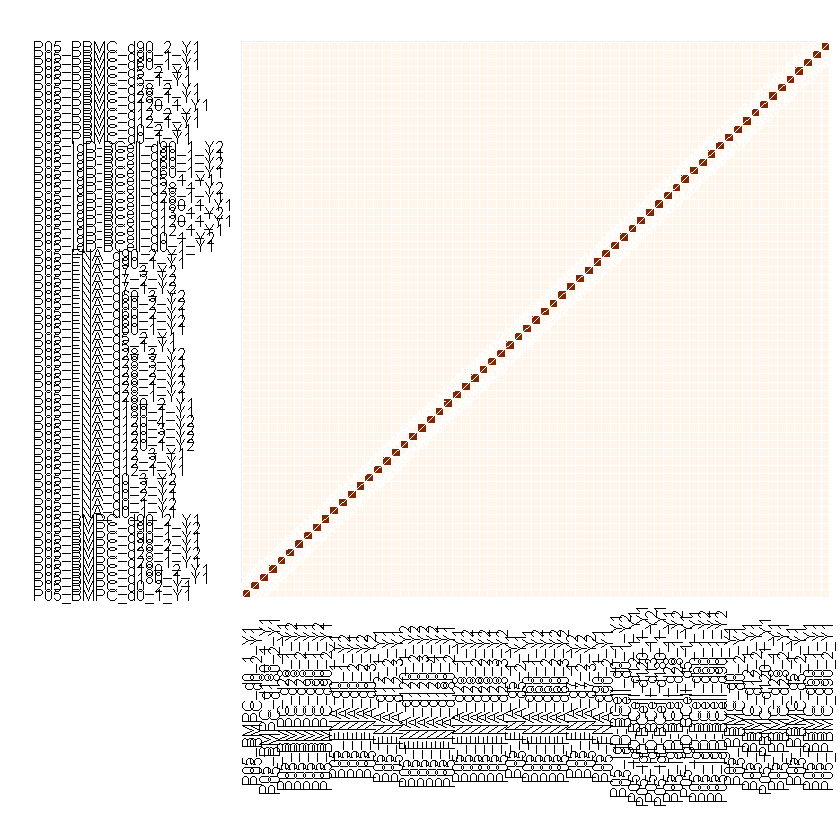

In [24]:
# Check overlap after removing duplicates
uniqueCell  <- singlecell_sharing_matrix(data.else, group="SAMPLE", cell="CELL", seq="SEQUENCE_IMGT")
p = plotOverlapSingleCell( list_objOverlap=list(uniqueCell, uniqueCell), titleText="", 
                           order_by=sort(colnames(uniqueCell@overlap_count)), 
                           sizeCount=3, sizeDiag=2.5)
plot(p)

Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning me

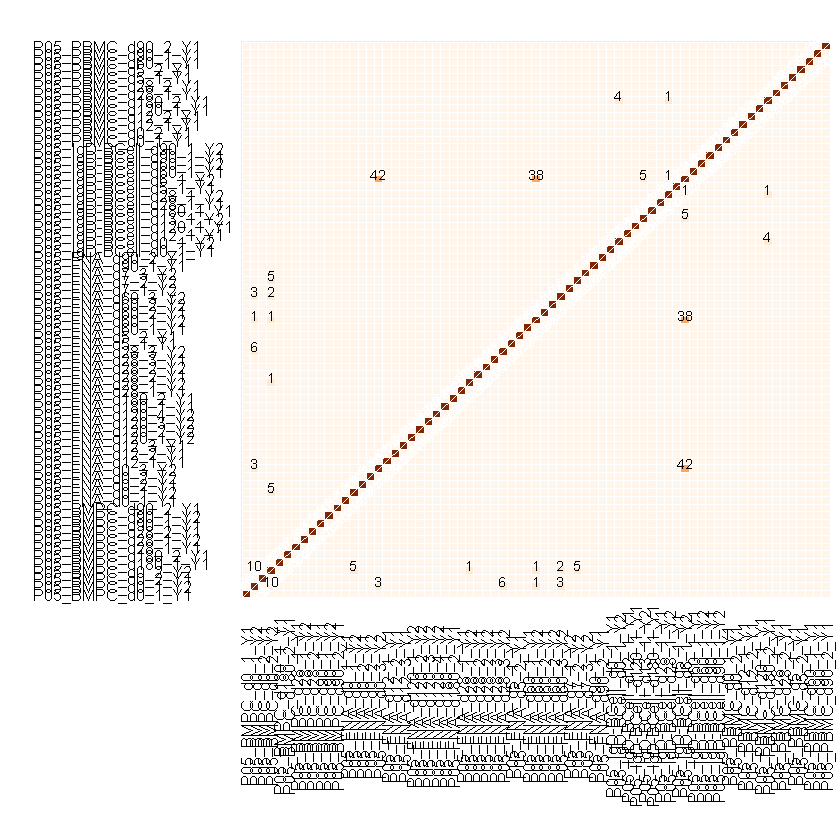

In [25]:
# Check overlap after removing duplicates
data.single.s = rbind(data.else, data.P05_BMPC_d0_2_Y2.s,data.P05_IgD_BCell_d6_1_Y2.s,
                     data.P05_BMPC_d0_1_Y2.s, data.P05_PBMC_d180_2_Y1.s)
uniqueCell  <- singlecell_sharing_matrix(data.single.s, group="SAMPLE", cell="CELL", seq="SEQUENCE_IMGT")
p = plotOverlapSingleCell( list_objOverlap=list(uniqueCell, uniqueCell), titleText="", 
                           order_by=sort(colnames(uniqueCell@overlap_count)), 
                           sizeCount=3, sizeDiag=2.5)
plot(p)

In [26]:
dim(data.single.s)
data.single.s = removeSingleCellDuplicates(data.single.s, group="SAMPLE", cell="CELL", seq="SEQUENCE_IMGT")
dim(data.single.s)

[1] 208834     60

Remove duplicates - cycle  1 


[1] 208578     60

Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning message in type.convert.default(X[[i]], ...):
"'as.is' should be specified by the caller; using TRUE"
Warning me

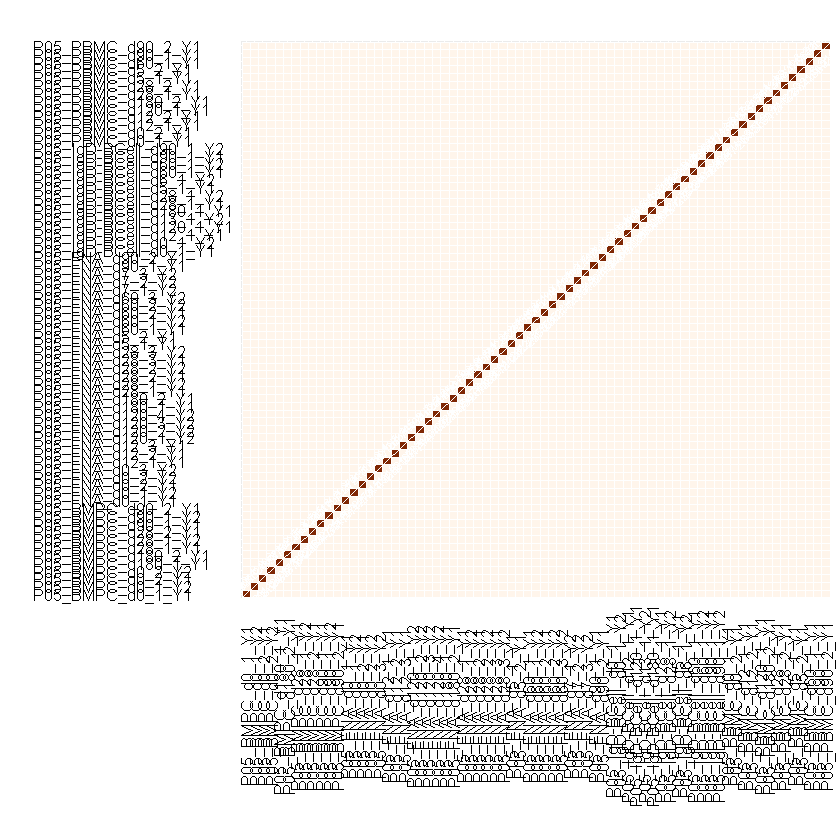

In [27]:
uniqueCell  <- singlecell_sharing_matrix(data.single.s, group="SAMPLE", cell="CELL", seq="SEQUENCE_IMGT")
p = plotOverlapSingleCell( list_objOverlap=list(uniqueCell, uniqueCell), titleText="", 
                           order_by=sort(colnames(uniqueCell@overlap_count)), 
                           sizeCount=3, sizeDiag=2.5)
plot(p)

In [28]:
data=rbind(data.ns, data.single.s)
dim(data)
write.table(data,file=paste0(subject,"_remDup.tsv"), quote=FALSE, sep="\t", row.names = FALSE)

[1] 373458     60

In [29]:
dim(data.P05_IgD_BCell_d6_1_Y2.s)
dim(data %>% filter(DATATYPE == "singleCell"  & is.AgClone=="Yes"
                                & SAMPLE=="P05_IgD-BCell_d6_1_Y2"  
                                 ))

[1] 3282   60

[1] 163  60